In [6]:
'''Here we testing the model's localization ability.

We consider multiple factors that could affect models' localization ability:
- The size of the object.
- The color of the object.
- The shape of the object.
- The background texture.
- The location of the object.
'''

from pydantic import BaseModel, Field
from PIL import Image, ImageDraw
import random
import math
import numpy as np

VALID_RESOLUTIONS = [
    # regular desktop resolution
    (1024, 768),
    (1280, 720),
    (1280, 800),
    (1920, 1080),
    (2560, 1440),
    (3840, 2160),
    (5120, 2880),
    (7680, 4320),
    # phone resolution
    (750, 1334),  # iPhone 6,7,8
    (828, 1792),  # iPhone XR
    (1080, 2256),  # vivo nex 3
    (1080, 2340),  # huawei p30
    (1080, 2376),  # vivo x50
    (1080, 2400),  # galaxy s20
    (1125, 2436),  # iPhone X, XS, 11 Pro
    (1170, 2532),  # iPhone 12, 12 Pro
    (1176, 2400),  # huawei mate30
    (1179, 2556),  # iphone 15
    (1200, 2670),  # xiaomi 15
    (1216, 2688),  # huawei mate 60
    (1228, 2700),  # huawei p60
    (1240, 2772),  # oppo find x6
    (1242, 2688),  # iPhone XS Max, 11 Pro Max
    (1260, 2800),  # vivo x90 pro
    (1284, 2778),  # iPhone 12 Pro Max
    (1290, 2796),  # iPhone 15 Pro Max
    (1344, 2992),  # google pixel 8 pro
    (1440, 3200),  # galaxy s20u
    (1440, 3088),  # galaxy note 20u
    (1440, 3168),  # oppo find x2
    (1440, 3168),  # oneplus 8 pro
    (1440, 3216),  # oneplus 11
]

COMMON_RESOLUTIONS = [
    (1280, 720),
    (828, 1792),  # iPhone XR
    (1920, 1080),
    (1080, 2400),  # galaxy s20
    (1179, 2556),  # iphone 15
    (1242, 2688),  # iPhone XS Max, 11 Pro Max
    (1440, 3216),  # oneplus 11
    (3840, 2160),
]


class Resolution(BaseModel):
    width: int
    height: int


class Position(BaseModel):
    x: int = Field(..., title='The x coordinate of the object.')
    y: int = Field(..., title='The y coordinate of the object.')


class BasicObject(BaseModel):
    color: str | tuple[int, int,
                       int] = Field(..., title='The color of the object.')
    bbox: list[int, int, int,
               int] = Field(..., title='The bounding box of the object.')
    shape: str = "Unknown"

    def draw(self, img: Image.Image, pos: Position):
        raise NotImplementedError

    def validate_point(self, pos: Position):
        raise NotImplementedError


class RectangleObject(BasicObject):
    shape: str = "Rectangle"
    width: int = Field(..., title='The width of the object.')
    height: int = Field(..., title='The height of the object.')

    def draw(self, img: Image.Image, pos: Position):
        draw = ImageDraw.Draw(img)
        x1, y1 = pos.x, pos.y
        x2, y2 = x1+self.width, y1+self.height
        draw.rectangle([x1, y1, x2, y2], fill=self.color)
        return img

    def validate_point(self, pos: Position):
        return 0 <= pos.x and pos.x <= self.bbox[2] and 0 <= pos.y and pos.y <= self.bbox[3]


class CircleObject(BasicObject):
    shape: str = "Circle"
    radius: int = Field(..., title='The radius of the object.')

    def draw(self, img: Image.Image, pos: Position):
        draw = ImageDraw.Draw(img)
        x1, y1 = pos.x, pos.y
        x2, y2 = x1+self.radius*2, y1+self.radius*2
        draw.ellipse([x1, y1, x2, y2], fill=self.color)
        return img

    def validate_point(self, pos: Position):
        # first calculate the distance between the pos to bbox center
        d = ((pos.x-self.bbox[2]/2)**2+(pos.y-self.bbox[3]/2)**2)**(0.5)
        if d <= self.radius:
            return True
        else:
            return False


class LocaliationTestItem(BaseModel):
    res: Resolution
    obj: BasicObject
    topleft_pos: Position
    background: str | tuple[int, int,
                            int] = Field(..., title='The background color of the image.')

    @property
    def center(self):
        return Position(x=self.topleft_pos.x+self.obj.bbox[2]//2, y=self.topleft_pos.y+self.obj.bbox[3]//2)

    def draw(self):
        back = Image.new(
            'RGB', (self.res.width, self.res.height), color=self.background)
        img = self.obj.draw(back, self.topleft_pos)
        return img

    def validate_point(self, pos: Position):
        delta_pos = Position(x=pos.x-self.topleft_pos.x,
                             y=pos.y-self.topleft_pos.y)
        return self.obj.validate_point(delta_pos)

    def validate_bbox(self, bbox: list[int, int, int, int], threshold: float = 0.5):
        """True if IoU is larger than threshold"""
        x1, y1 = self.topleft_pos.x, self.topleft_pos.y
        x2, y2 = x1+self.obj.bbox[2], y1+self.obj.bbox[3]
        x3, y3 = bbox[0], bbox[1]
        x4, y4 = bbox[0]+bbox[2], bbox[1]+bbox[3]
        # calculate the IoU
        x5 = max(x1, x3)
        y5 = max(y1, y3)
        x6 = min(x2, x4)
        y6 = min(y2, y4)
        inter_area = max(0, x6-x5)*max(0, y6-y5)
        union_area = (x2-x1)*(y2-y1) + (x4-x3)*(y4-y3) - inter_area
        return inter_area/union_area >= threshold


def build_full_localization_test(
        resolutions: list[tuple[int, int]] = COMMON_RESOLUTIONS,
        windows_ratio: list[float] = [0.1, 0.05, 0.01, 0.005],
        max_repeat_times: int = 1,
        delta_size=0.2
        ) -> dict[float, dict[tuple[int, int], list[LocaliationTestItem]]]:
    dataset = {}
    total_size = 0
    for ws in windows_ratio:
        for res in resolutions:
            if res not in dataset:
                dataset[res] = {}
            dataset[res][ws] = []
            width,height = res
            # calculate how many samples is sufficient for the ws
            windows_area = int(ws*width*height)
            minimum_square_len = math.floor(math.sqrt(windows_area))

            # 计算接近min_samples的行数和列数
            cols = math.ceil(2*width/minimum_square_len*math.sqrt(max_repeat_times))
            rows = math.ceil(2*height/minimum_square_len*math.sqrt(max_repeat_times))
            
            # 生成网格点
            x = np.linspace(0, width, cols)
            y = np.linspace(0, height, rows)

            # 计算网格间距
            x_spacing = width / (cols - 1)
            y_spacing = height / (rows - 1)
            
            # 创建网格
            xv, yv = np.meshgrid(x, y)
            grid_points = np.column_stack([xv.ravel(), yv.ravel()])
            
            # 生成随机偏移
            shifts_x = (np.random.rand(*grid_points[:, 0].shape) - 0.5) * x_spacing
            shifts_y = (np.random.rand(*grid_points[:, 1].shape) - 0.5) * y_spacing
            
            # 应用偏移
            shifted_points = grid_points + np.column_stack([shifts_x, shifts_y])

            # 确保偏移后的点在边界内
            shifted_points[:, 0] = np.clip(shifted_points[:, 0], 0, width-1)
            shifted_points[:, 1] = np.clip(shifted_points[:, 1], 0, height-1)

            def sample_objects(random_color = False):
                objs_type = np.random.randint(2,size=len(shifted_points))
                objs_area = ws*(
                    1+np.random.uniform(
                        -delta_size,
                        delta_size,
                        len(shifted_points))
                        )*width*height
                if random_color:
                    color1 = np.random.randint(0,255,(len(shifted_points),3))
                    color2 = np.random.randint(0,255,(len(shifted_points),3))
                else:
                    color1 = []
                    color2 = []
                    for bright in np.random.randint(0,1,(len(shifted_points))):
                        if bright:
                            color1.append((255,255,255))
                            color2.append((0,0,0))
                        else:
                            color1.append((0,0,0))
                            color2.append((255,255,255))
                # print(len(objs_type),len(shifted_points),len(objs_area),len(color1),len(color2))

                for otype,point,area,c1,c2 in zip(objs_type,shifted_points,objs_area,color1,color2):
                    if otype == 0:
                        # rectangle
                        # center point must be the `point`
                        max_width = min(point[0]*2,2*(width-point[0]),area/4)
                        min_width = max(4,math.sqrt(0.2*area))
                        if min_width > max_width:
                            # print(min_width,max_width)
                            continue

                        # Calculate width and height with a more balanced approach
                        aspect_ratio = random.uniform(0.5, 2)  # Adjust the range as needed for balance
                        obj_width = int(math.sqrt(area / aspect_ratio))
                        obj_height = int(area / obj_width)

                        # Ensure width and height are within bounds
                        obj_width = max(int(min_width), min(int(max_width), obj_width))
                        obj_height = int(area / obj_width)
                        obj = RectangleObject(width=obj_width, height=obj_height, color=c1, bbox=[
                                            0, 0, obj_width, obj_height])

                    if otype == 1:
                        # circle
                        max_radius = int(min(point[0],(width-point[0]),point[1],(height-point[1])))

                        if max_radius<=0:
                            continue
                            
                        radius = min(int((area/math.pi)**0.5),max_radius)
                        obj = CircleObject(radius=radius, color=c1, bbox=[
                               0, 0, 2*radius, 2*radius])
                
                    # print(max(point[0]-obj.bbox[2]//2,0))
                    dataset[res][ws].append(LocaliationTestItem(
                        res=Resolution(width=width,height=height),
                        obj=obj,
                        topleft_pos=Position(
                            x=int(max(point[0]-obj.bbox[2]//2,0)),
                            y=int(max(point[1]-obj.bbox[3]//2,0))
                        ),
                        background=c2
                    ))



            # sample simple colors with black and white background
            sample_objects(random_color=False)
            sample_objects(random_color=True)

            # print(f"Res: {res}, ws: {ws}, total: {len(dataset[res][ws])}")
            total_size += len(dataset[res][ws])
    # print("Total: ",total_size)
    return dataset



In [7]:
import asyncio
import matplotlib.pyplot as plt
from typing import List, Literal, Callable, Coroutine, Any
from scipy.ndimage import gaussian_filter
import numpy as np
import math

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

def calculate_color_delta(color1,color2):
    c1 = sRGBColor(color1[0],color1[1],color1[2])
    c2 = sRGBColor(color2[0],color2[1],color2[2])
    c1_lab = convert_color(c1,LabColor)
    c2_lab = convert_color(c2,LabColor)
    return delta_e_cie2000(c1_lab, c2_lab)

class LocalizationTester:
    def __init__(
            self,
            resolutions: list[tuple[int, int]] = COMMON_RESOLUTIONS,
            windows_ratio: list[float] = [0.1, 0.05, 0.01, 0.005],
            max_repeat_times: int = 1
    ):
        self.data = build_full_localization_test(
            resolutions=resolutions,
            windows_ratio=windows_ratio,
            max_repeat_times=max_repeat_times
        )

    def __len__(self):
        total = 0
        for res, res_testset in  self.data.items():
            for ws,subset  in res_testset.items():
                total+=len(subset)
        return total
    
    def __getitem__(self, idx):
        for res, res_testset in  self.data.items():
            for ws,subset  in res_testset.items():
                if idx < len(subset):
                    return subset[idx]
                else:
                    idx -= len(subset)
        raise IndexError

    async def run(
        self,
        completion_func: Callable[[LocaliationTestItem], Coroutine[Any,Any,Position | list[int, int, int, int]]],
    ):
        statics = []

        for res, res_testset in  self.data.items():
            for ws,subset  in res_testset.items():
                meta = {
                    "Windows Ratio": ws,
                    "Resolution": res,
                }
                tasks = [asyncio.create_task(completion_func(
                    item), name=str(idx)) for idx, item in enumerate(subset)]

                done, pending = await asyncio.wait(tasks)

                test = []
                labels = []
                for item in done:
                    ret = item.result()
                    idx = int(item.get_name())
                    if idx < len(subset):
                        t = subset[idx]
                        test.append(t)
                        if isinstance(ret, Position):
                            labels.append(t.validate_point(ret))
                        else:
                            labels.append(t.validate_bbox(ret))

                    else:
                        print(f"Unkown index: {idx}")

                meta["Discernible"] = sum(labels)/len(labels) > 0.5
                statics.append({
                    "meta": meta,
                    "results": {
                        "test":test,
                        "labels": labels
                    }
                })
                print(meta)
        return statics
    

def draw_res_correctness(statics, sigma:float = None, save_path:str = None):
    res_x,res_y = statics["meta"]["Resolution"]
    ws_ratio:float = statics["meta"]["Windows Ratio"]
    x = []
    y = []

    for t,label in zip(statics["results"]["test"],statics["results"]["labels"]):
        t:LocaliationTestItem
        x.append(t.center.x)
        y.append(t.center.y)
    
    x=  np.array(x)
    y = np.array(y)
    labels = np.array(statics["results"]["labels"])

    windows_area = int(ws_ratio*res_x*res_y)
    minimum_square_len = math.sqrt(windows_area)
    fig_res_x = math.ceil(res_x/minimum_square_len)
    fig_res_y = math.ceil(res_y/minimum_square_len)

    
    x_bins = np.linspace(0,res_x,fig_res_x+1)
    y_bins = np.linspace(0,res_y,fig_res_y+1)

    x_inds = np.digitize(x,x_bins) - 1
    y_inds = np.digitize(y,y_bins) - 1

    # 初始化计数数组
    true_counts = np.zeros((fig_res_x, fig_res_y))
    total_counts = np.zeros((fig_res_x, fig_res_y))

    # 计算每个网格单元内的 True 和总数
    for xi, yi, label in zip(x_inds, y_inds, labels):
        # 确保索引在合理范围内
        if 0 <= xi < res_x and 0 <= yi < res_y:
            total_counts[xi, yi] += 1
            if label:
                true_counts[xi, yi] += 1

    # 计算正确率：True 的比例
    accuracy = np.divide(
        true_counts, 
        total_counts, 
        out=np.zeros_like(true_counts),  # 避免除以零
        where=total_counts != 0
    )
    if sigma is not None:
        accuracy = gaussian_filter(accuracy, sigma=sigma)

    accuracy[total_counts==0] = np.nan

    plt.figure(figsize=(8,8*(res_y/res_x)+0.5))
    cmap = plt.get_cmap('RdYlGn')
    img = plt.imshow(
        accuracy.T,  # 转置以匹配 x 和 y 轴
        origin='lower',       # 原点在左下角
        extent=(0, res_x, 0, res_y),  # 定义坐标范围
        cmap=cmap,
        vmin=0, vmax=1,        # 正确率范围从0到1
        aspect='auto'          # 自动调整纵横比
    )

    # 绘制图例
    plt.colorbar(img, orientation='vertical')

    plt.gca().set_aspect('equal', adjustable='box')  # 设置纵横比为1:1
    plt.title(f'Windows Ratio: {ws_ratio}\nResolution: {res_x}x{res_y}')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

In [8]:
import fire
import io
import asyncio
from typing import Literal
from openai import AsyncOpenAI
import base64
import json
import re

In [9]:
tester = LocalizationTester()

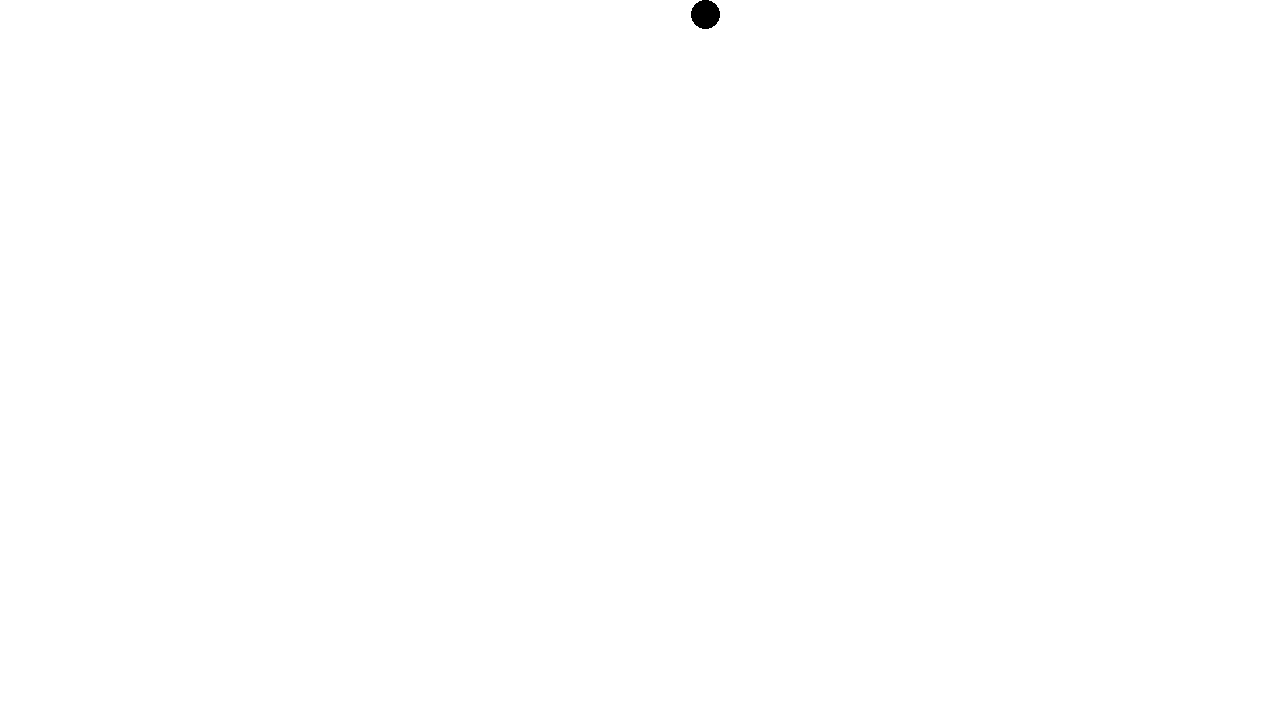

In [33]:
tester[1000].draw()

In [39]:
sem = asyncio.Semaphore(64)
async def completions(item:LocaliationTestItem)->Position:
    async with sem:
        img= item.draw()
        # convert to jpeg codec
        img_io = io.BytesIO()
        img.save(img_io, "JPEG")
        img_io.seek(0)

        prompt = f"Given the image, please give a point's coordinate in the {item.obj.shape} in form of <point>x,y</point>"
        client = AsyncOpenAI(
            api_key="sk-1234",
            base_url="http://localhost:8000/v1"
        )
        response = await client.chat.completions.create(
            messages=[
                {"role":"user",
                    "content":[
                    {"type":"text","text":prompt},
                    {"type":"image_url","image_url":{"url":"data:image/jpeg;base64,"+base64.b64encode(img_io.read()).decode()}},
                ]}
            ],
            model="qwen2vl"
        )
        response = response.choices[0].message.content
        # extract the point
        match = re.search(r"<point>(\d+),(\d+)</point>",response)
        if match:
            x,y = match.groups()
            return Position(x=int(x),y=int(y))
        else:
            print("No point found: ",response)


In [40]:
await completions(tester[1000])

Position(x=0, y=0)